# Progetto MOBD A.A 2024/2025
Simone Ercole (mat. 0360105) \
Federico Pepe (mat. 0365363)


---
 L'obiettivo del progetto è quello di sviluppare una rete neurale per risolvere un problema di classificazione multi-classe, applicando le conoscenze acquisite durante il corso. \

 Per tale obiettivo è stato scelto un dataset chiamato **BodyPerformanceData** \(dati raccolti dalla *Korea Sports Promotion Foundation*),
 il quale descrive il grado di performance fisica di una persona, basandosi su informazioni personali e dati raccolti durante le sedute di allenamento.

 Le classi che devono essere predette sono quattro : A, B, C, D \

 Inoltre, le classi sono rappresentate in ordine decrescente, dove la classe A corrisponde al grado massimo possibile.


---






## 0. Passo Preliminare : Importazione di tutte le librerie

In questa sezione saranno caricate tutte le librerie utilizzate per il corretto svolgimento del progetto.

In [ ]:
import io
import math
import time
import pandas             as pd
import numpy              as np
import matplotlib.pyplot  as plt
import seaborn            as sns
import tensorflow         as tf

from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import train_test_split
from sklearn.pipeline           import Pipeline
from sklearn.preprocessing      import StandardScaler
from sklearn.compose            import ColumnTransformer
from sklearn.pipeline           import make_pipeline
from IPython.display            import clear_output
from sklearn.metrics            import confusion_matrix
from sklearn.utils.multiclass   import unique_labels
from sklearn.metrics            import precision_score, recall_score, f1_score
from google.colab               import files

## 1. Importazione ed analisi del dataset

In [ ]:
uploaded = files.upload()

Saving bodyPerformance.csv to bodyPerformance.csv


In [ ]:
DataSet = pd.read_csv(io.BytesIO(uploaded['bodyPerformance.csv']))
DataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


Il numero di features del dataset corrisponde a 12, di cui :

*   Due categoriche (Class, gender)
*   Dieci numeriche

Non appaiono valori nulli in nessuna delle features. \

Il numero di campioni totali è : 13.393


---
Prima di procedere con l'analisi delle features è importante cercare di comprendere il significato di ognuna di esse. A seguire, viene riportata la seguente tabella contenente, per ogni feature, la corrispettiva descrizione.




<table border="1">
    <thead>
        <tr>
            <th>Numero Attributo</th>
            <th>Nome Attributo</th>
            <th>Descrizione</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>0</td>
            <td>Age</td>
            <td>Età dell'individuo</td>
        </tr>
        <tr>
            <td>1</td>
            <td>Gender</td>
            <td>Sesso dell'individuo</td>
        </tr>
        <tr>
            <td>2</td>
            <td>Height_cm</td>
            <td>Altezza in cm</td>
        </tr>
        <tr>
            <td>3</td>
            <td>Weight_kg</td>
            <td>Peso in kili</td>
        </tr>
        <tr>
            <td>4</td>
            <td>body fat_%</td>
            <td>Percentuale di grasso nell'individuo</td>
        </tr>
        <tr>
            <td>5</td>
            <td>diastolic</td>
            <td>Pressione sangue distolica (min)</td>
        </tr>
        <tr>
            <td>6</td>
            <td>systolic</td>
            <td>Pressione sangue sistolica (min)</td>
        </tr>
        <tr>
            <td>7</td>
            <td>gripForce</td>
            <td>Forza della presa dell'individuo</td>
        </tr>
        <tr>
            <td>8</td>
            <td>sit and bend forward_cm</td>
            <td>Misura della massima distanza raggiunta stando in posizione seduta e cercando di arrivare ai piedi</td>
        </tr>
        <tr>
            <td>9</td>
            <td>sit-ups counts</td>
            <td>Numero di addominali eseguiti in 2 minuti</td>
        </tr>
        <tr>
            <td>10</td>
            <td>broad jump_cm</td>
            <td>Distanza salto in lungo da fermo in cm</td>
        </tr>
        <tr>
            <td>11</td>
            <td>class</td>
            <td>Grado di performance da predire</td>
        </tr>
    </tbody>
</table>



---

Possiamo ora procedere con l'analisi delle features, iniziando con lo studio degli istogrammi delle features numeriche.

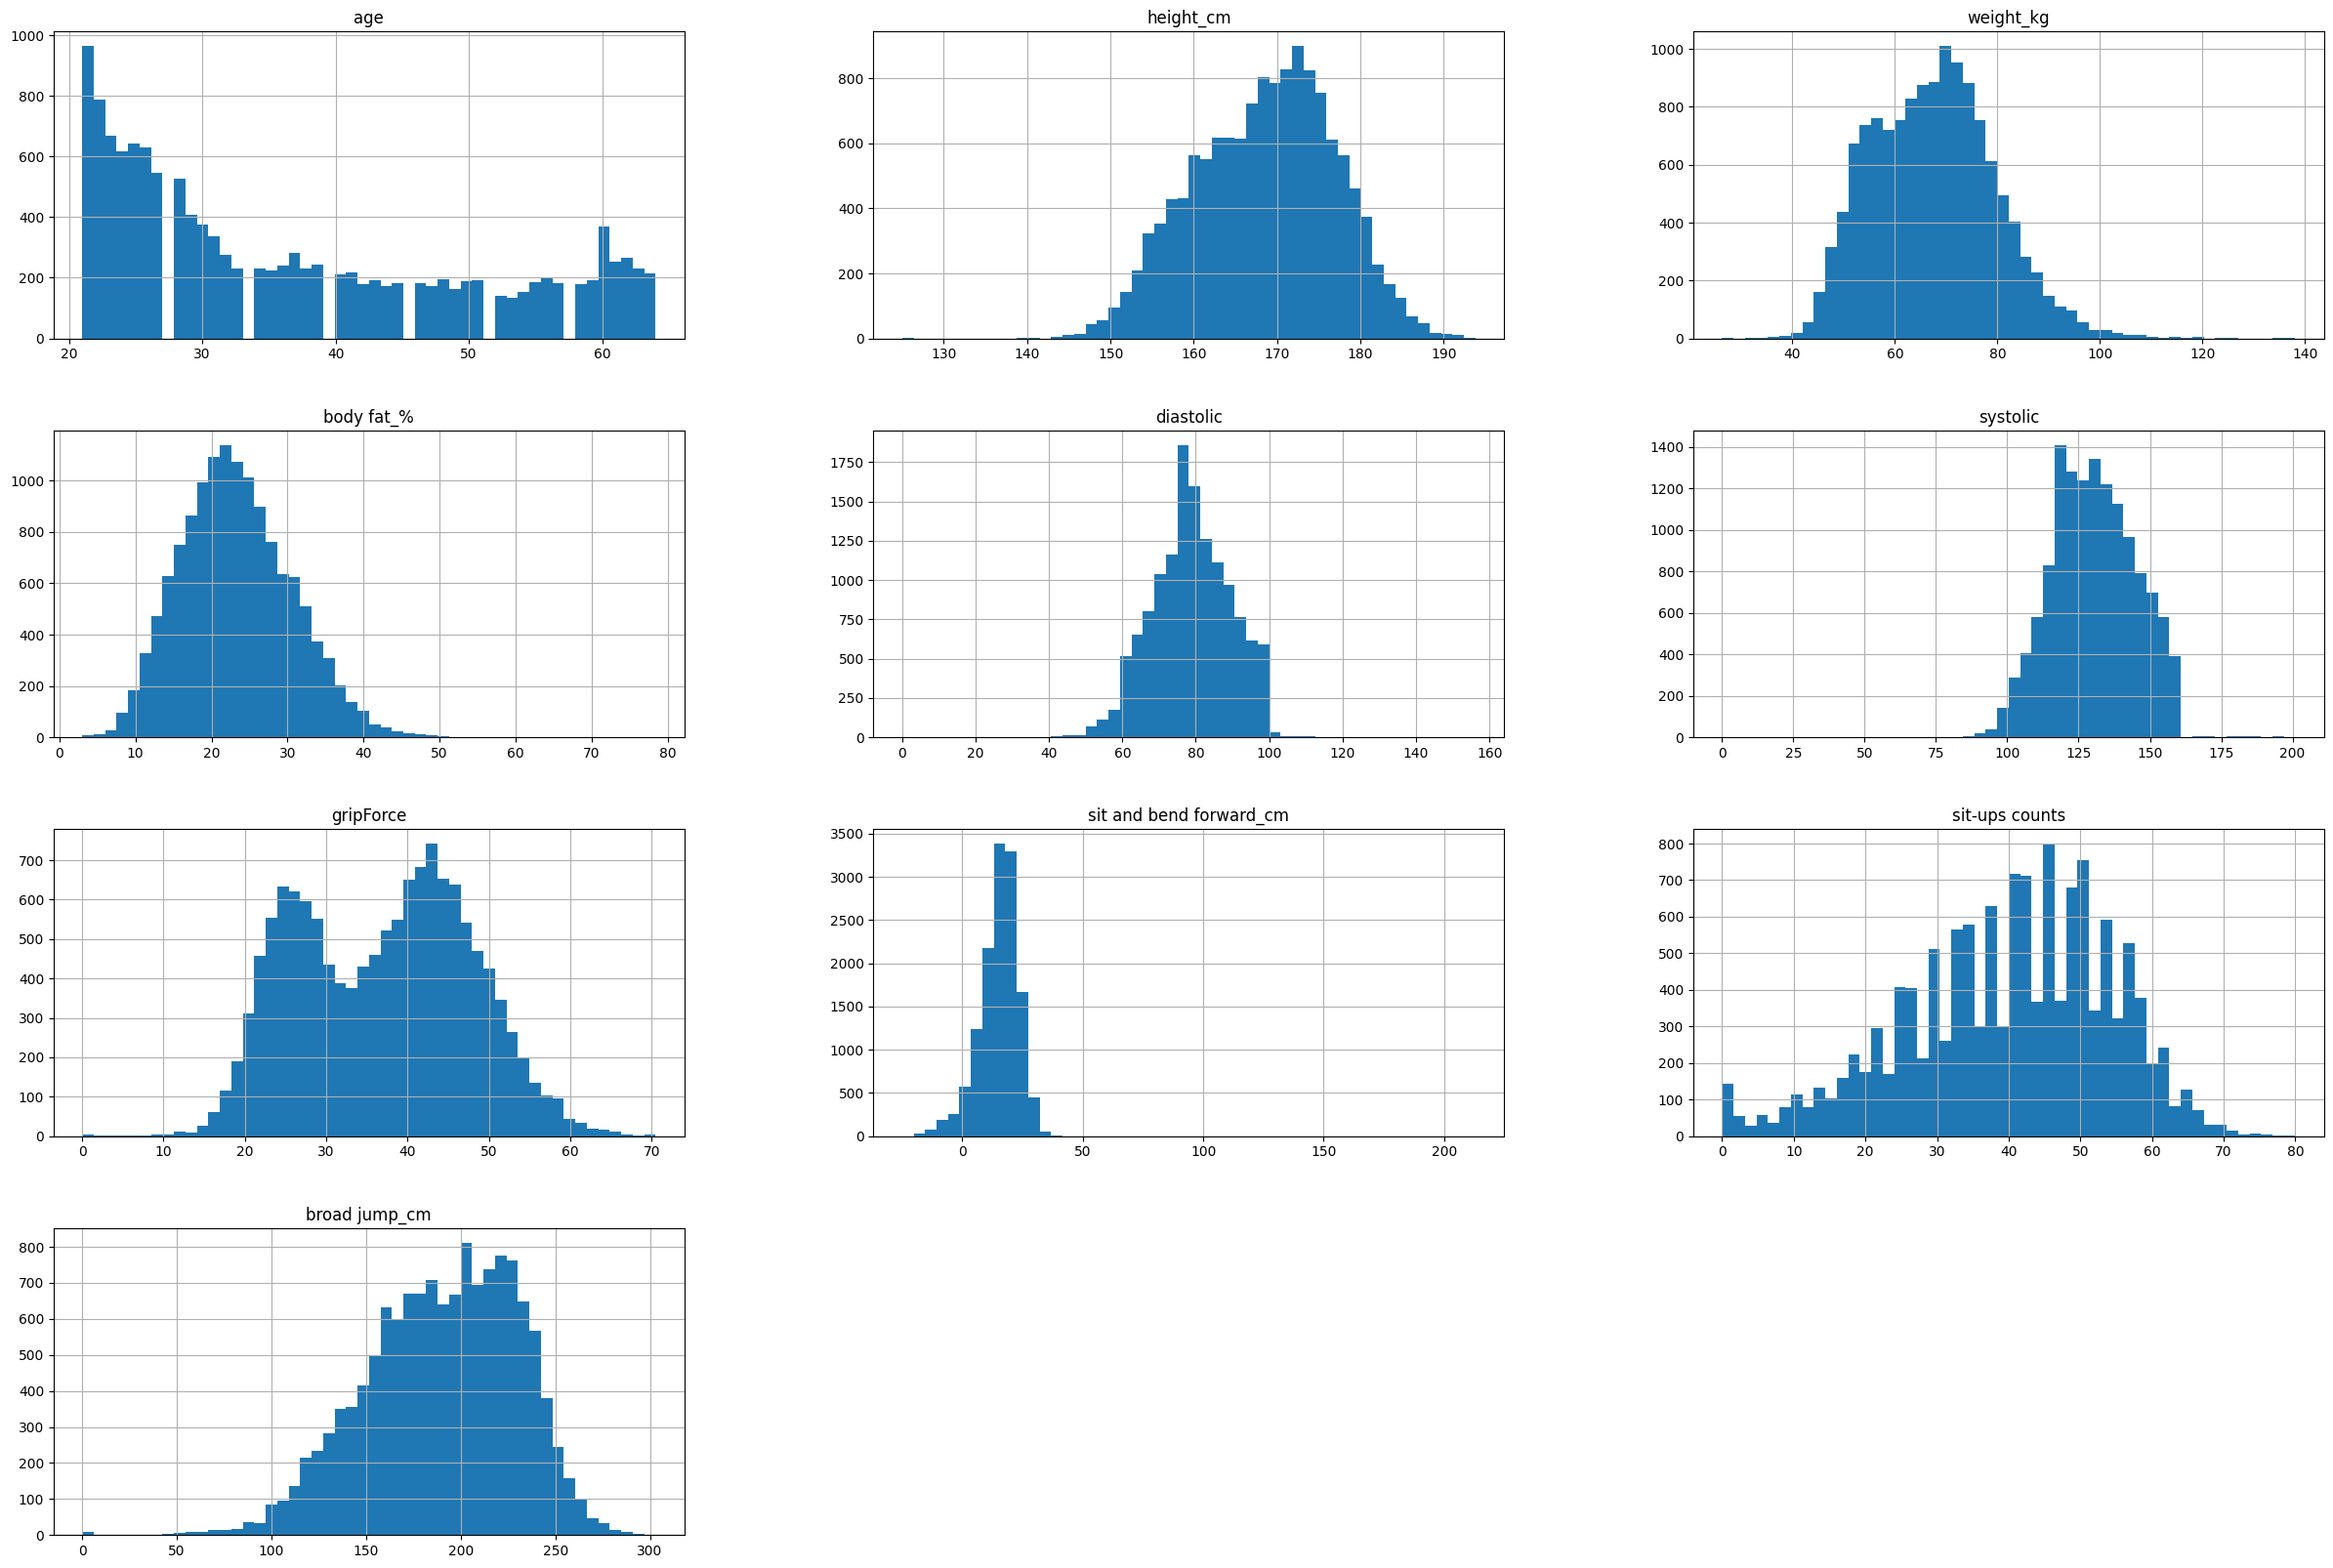

In [ ]:
DataSet.hist(bins = 50, figsize = (30,20))
plt.show()

Dall'analisi dei grafici, non sembrano esserci informazioni rilevanti da evidenziare, per quanto concerne le features numeriche.  
Possiamo, quindi, passare all'analisi delle features categoriche.

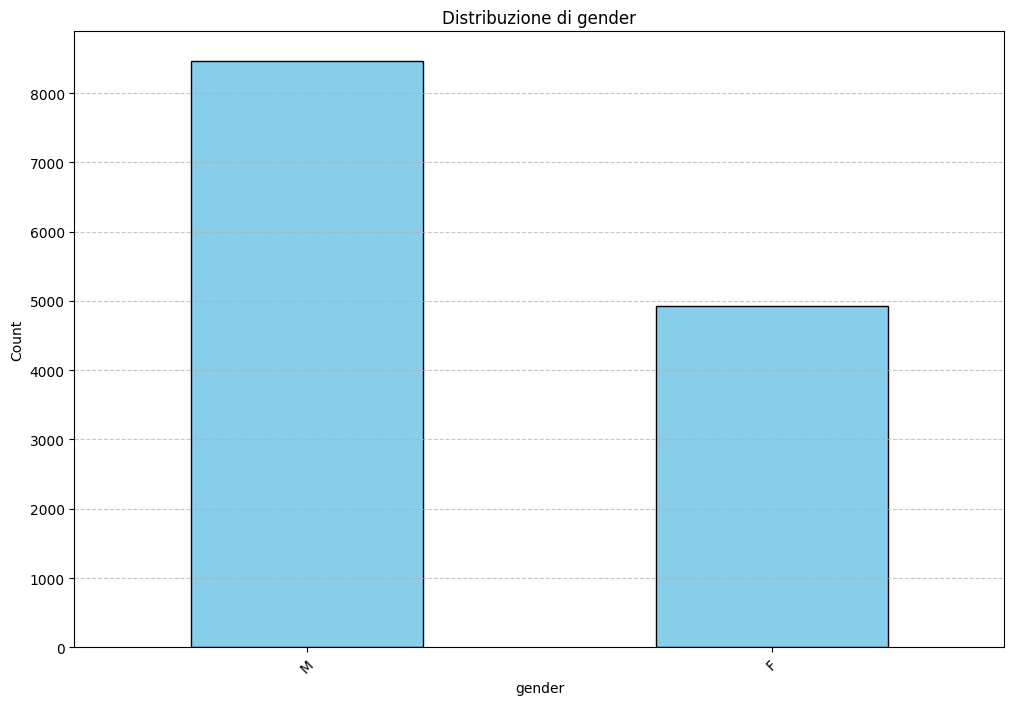

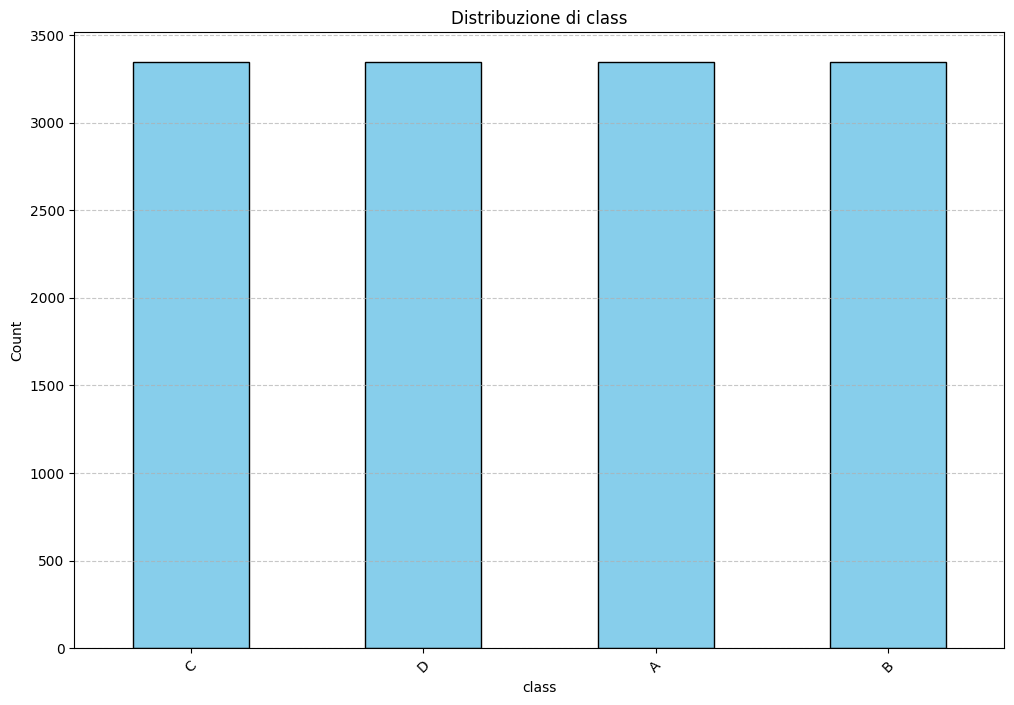

In [ ]:
categorical_columns = DataSet.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    plt.figure(figsize=(12, 8))
    DataSet[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribuzione di {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Dall'analisi delle features categoriche, si evince come il numero di persone di sesso maschile sia maggiore delle persone di sesso femminile.
Un altro aspetto non trascurabile, lo osserviamo nella feature Class, dove possiamo apprezzare come il Dataset sia bilanciato, in quanto ogni classe contiene lo stesso numero di campioni.

## 2. Preprocessamento del dataset



Dalla sezione precedente, abbiamo già verificato come tramite l'istruzione *DataSet.info()*, non siano presenti valori mancanti o nulli. Quindi l'ultimo controllo da eseguire è l'identificazione e successiva rimozione di eventuali valori duplicati.

In [ ]:
new_df = DataSet.copy()

In [ ]:
print(f"Number of duplicate rows: {new_df.duplicated().sum()}")

Number of duplicate rows: 1


In [ ]:
new_df = new_df.drop_duplicates()

In [ ]:
print(f"Number of duplicate rows: {new_df.duplicated().sum()}")

Number of duplicate rows: 0


E' stato trovato ed eliminato un solo campione nel Dataset.

---

A questo punto, possiamo ora procedere con la gestione delle features categoriche, attraverso l'uso della codifica *One-Hot-Encoding*. Trasformiamo tutte le features categoriche presenti nel dataset, ad eccezione della feature Class, in quanto è il nostro valore target.
In particolare sarà solamente convertita la colonna *gender*.


In [ ]:
#Codifica One Hot Encoding per la feature categorica gender
#   Creazione oggetto LabelEncoder
label_encoder = LabelEncoder()
categorical_features = new_df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features.remove('class')

#   Iterazione sulle feature categoriche e sue codifiche
for feature in categorical_features:
    if feature in new_df.columns:

        feature_data = new_df[feature]

        new_df[feature] = label_encoder.fit_transform(feature_data)
        encoded_feature = tf.keras.utils.to_categorical(new_df[feature])

        num_classes = encoded_feature.shape[1]
        new_cols = [f"{feature}_{i}" for i in range(num_classes)]

        encoded_df = pd.DataFrame(encoded_feature, columns=new_cols, index=new_df.index)
        new_df = pd.concat([new_df, encoded_df], axis=1)

        new_df = new_df.drop(columns=[feature])



Terminata la trasformazione della feature categorica *gender*, procediamo con la divisione del dataset in *train_set* e *test_set*, con le seguenti proporzioni :

*   Train_set   : 70% (9374 campioni)
*   Test_set    : 30% (4018 campioni)


In [ ]:
train_set, test_set = train_test_split(new_df, test_size=0.3, random_state=42, stratify=new_df['class'])

X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

Eseguita correttamente la partizione del *Dataset* in *train_set* e *test_set*, dobbiamo trasformare la colonna target, sia nel *train_set* che nel *test_set*, sfruttando nuovamente la codifica *One-Hot-Encoding*.


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
Y_train_encoder = label_encoder.transform(y_train)
classi = label_encoder.classes_
Y_train_encoder = tf.keras.utils.to_categorical(Y_train_encoder, num_classes=4)  #Vettore One hot Encoding

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_test)
Y_test_encoder = label_encoder.transform(y_test)
classi = label_encoder.classes_
Y_test_encoder = tf.keras.utils.to_categorical(Y_test_encoder, num_classes=4)  #Vettore One hot Encoding

Concluso il preprocessamento delle feature categoriche si procede con quello
delle features numeriche. La decisione presa è stata quella di normalizzare i campioni, in modo tale che abbiano media zero e varianza unitaria. \
Questa scelta è stata presa in quanto il modello gode di performance migliori, rispetto all'utilizzo di dati non normalizzati.

La normalizzazione è stata eseguita attraverso l'uso della libreria *Scikit-Learn*, la quale mette a disposizione il modulo *StandardScaler*.

In [ ]:
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist() #Identifichiamo le colonne numeriche del dataset

In [ ]:
#Applichiamo la trasformazione dello standard scaler solo alle feature numeriche (numeric_columns)

num_pipeline = Pipeline([
  ('scaler', StandardScaler()),
])

transformer = ColumnTransformer(
    [
     ('numerical', num_pipeline, numeric_columns),
    ]
    )


pipe = make_pipeline(transformer)
pipe.fit(X_train) #Fit solo sui dati di training

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'height_cm',
                                                   'weight_kg', 'body fat_%',
                                                   'diastolic', 'systolic',
                                                   'gripForce',
                                                   'sit and bend forward_cm',
                                                   'sit-ups counts',
                                                   'broad jump_cm', 'gender_0',
                                                   'gender_1'])]))])

In [ ]:
#Applichiamo la trasformazione a train e test set
X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test)

##  3.  Creazione della rete

In questa sezione analizziamo le funzionalità offerte dalla classe **NeuralNetwork**.

La classe viene inizializzata specificando l'architettura della rete sotto forma di lista, ad esempio [12, 12, 6, 4], dove ogni elemento rappresenta il numero di neuroni nei vari livelli della rete. Inoltre, è possibile definire la funzione di attivazione da utilizzare in ciascun livello, **escluso quello di uscita**. Le funzioni attivazione supportate sono:

1. *ReLU*  
2. *tanh*  
3. *Leaky ReLU*

Per il livello di uscita viene adottata la funzione **softmax**, in quanto il problema affrontato è di classificazione multiclasse.

L'inizializzazione dei pesi è coerente con la funzione di attivazione selezionata. In particolare:

- Se la funzione è *ReLU* o *Leaky ReLU*, viene utilizzata la **He Initialization**.  
- In caso di *tanh*, viene adottata la **Glorot Initialization**, in linea con le best practice note.

Poiché si tratta di un problema di classificazione multiclasse, la funzione di loss scelta è la **Cross-Entropy**.

Per il calcolo del gradiente della loss rispetto ai pesi, viene implementato l’algoritmo di **Backpropagation**, invocato all’interno del metodo *fit*.

---

Il metodo *fit* gestisce l'addestramento della rete neurale mediante **Stochastic Gradient Descent con momentum**, con il valore di β fissato a **0.99**.

È possibile personalizzare diversi iperparametri:

1. Numero di epoche  
2. Dimensione del minibatch  
3. Learning rate iniziale  
4. Tasso di regolarizzazione  
5. Tipo di regolarizzazione (*L1* o *L2*)

A inizio di ogni epoca, il learning rate viene aggiornato secondo una procedura di **decadimento lineare adattativo**:

$$
\text α_k  = \begin{cases} α_0 - \frac{k}{τ}  (α_0 - α_τ) & k \leq τ\\ α_τ & k>τ \end{cases}
$$

Dove:

- $\alpha_k$ : Learning rate all'epoca $k$-esima
- $\alpha_0$ : Learning rate iniziale  
- $\alpha_\tau = 0.01 \cdot \alpha_0$: Learning rate minimo  
- $\tau = \lceil 0.8 \cdot \text{epochs} \rceil$  
- $k$ : Epoca corrente






In [ ]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation_name = activation
        self.loss = 0

        self.weights = []
        self.biases = []

        for i in range(self.num_layers - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i + 1]

            if self.activation_name == "tanh":
                limit = np.sqrt(6 / (n_in + n_out))
                self.weights.append(np.random.uniform(-limit, limit, (n_out, n_in)))
            else:
                self.weights.append(np.random.randn(n_out, n_in) * np.sqrt(2. / n_in))

            self.biases.append(np.zeros((n_out, 1)))

    def activation_function(self, x, name):
        if name == "relu":
            return np.maximum(0, x)
        elif name == "leaky_relu":
            return np.maximum(0.01 * x, x)
        elif name == "softmax":
            exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
            return exp_x / np.sum(exp_x, axis=0, keepdims=True)
        elif name == "tanh":
            return np.tanh(x)
        else:
            raise ValueError(f"Unsupported activation: {name}")

    def activation_derivative(self, activation_output, name):
        if name == "relu":
            return (activation_output > 0).astype(float)
        elif name == "leaky_relu":
            return np.where(activation_output > 0, 1, 0.01)
        elif name == "tanh":
            return 1 - activation_output ** 2
        else:
            raise ValueError(f"Unsupported derivative: {name}")

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=0))

    def forward_propagation(self, X, y=None, reg_rate=0, reg_type=None):
        self.activations = [X]
        self.preActivations = [None]

        A = X
        for i in range(self.num_layers - 1):
            Z = np.dot(self.weights[i], A) + self.biases[i]
            self.preActivations.append(Z)

            if i == self.num_layers - 2:
                A = self.activation_function(Z, "softmax")
            else:
                A = self.activation_function(Z, self.activation_name)
            self.activations.append(A)

        if y is not None:
            base_loss = self.cross_entropy_loss(y, self.activations[-1])

            reg_loss = 0
            if reg_type == "l2":
                reg_loss = (reg_rate / (2 * X.shape[1])) * sum(np.sum(w ** 2) for w in self.weights)
            elif reg_type == "l1":
                reg_loss = (reg_rate / X.shape[1]) * sum(np.sum(np.abs(w)) for w in self.weights)

            loss = base_loss + reg_loss
            return loss
        return None

    def backward_propagation(self, X, y, reg_rate, reg_type=None):
        loss = self.forward_propagation(X, y, reg_rate, reg_type)
        batch_size = X.shape[1]

        gradients_weights = [None] * (self.num_layers - 1)
        gradients_biases = [None] * (self.num_layers - 1)

        delta = self.activations[-1] - y  # softmax + cross-entropy simplification

        # Output layer
        l1_term = (reg_rate / batch_size) * np.sign(self.weights[-1]) if reg_type == "l1" else 0
        l2_term = (reg_rate / batch_size) * self.weights[-1] if reg_type == "l2" else 0
        gradients_weights[-1] = (
            np.dot(delta, self.activations[-2].T) / batch_size + l1_term + l2_term
        )
        gradients_biases[-1] = np.sum(delta, axis=1, keepdims=True) / batch_size

        # Hidden layers
        for l in range(self.num_layers - 3, -1, -1):
            da = np.dot(self.weights[l + 1].T, delta)
            derivative = self.activation_derivative(self.activations[l + 1], self.activation_name)
            dz = da * derivative
            delta = dz

            l1_term = (reg_rate / batch_size) * np.sign(self.weights[l]) if reg_type == "l1" else 0
            l2_term = (reg_rate / batch_size) * self.weights[l] if reg_type == "l2" else 0

            gradients_weights[l] = (
                np.dot(delta, self.activations[l].T) / batch_size + l1_term + l2_term
            )
            gradients_biases[l] = np.sum(delta, axis=1, keepdims=True) / batch_size

        return gradients_weights, gradients_biases, loss

    def adapt_learning_rate(self, k, t, a0):
        at = 0.01 * a0
        if k > t:
            return at
        else:
            return a0 - (k / t) * (a0 - at)

    def fit(self, epochs, X, y, minibatch_size, learning_rate, reg_rate, reg_type=None, show_plots = False):
        all_losses = []
        all_accuracies = []
        t = math.floor(0.8 * epochs)
        momentum = 0.99

        vel_weights = [np.zeros_like(w) for w in self.weights]
        vel_biases = [np.zeros_like(b) for b in self.biases]

        n_samples = X.shape[0]

        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            n_minibatches = math.ceil(n_samples / minibatch_size)
            batches_X = np.array_split(X_shuffled, n_minibatches)
            batches_y = np.array_split(y_shuffled, n_minibatches)

            epoch_loss = 0
            for X_batch, y_batch in zip(batches_X, batches_y):
                X_batch = X_batch.T
                y_batch = y_batch.T

                gradients_weights, gradients_biases, batch_loss = self.backward_propagation(
                    X_batch, y_batch, reg_rate, reg_type
                )

                ak = self.adapt_learning_rate(epoch, t, learning_rate)

                for i in range(len(self.weights)):
                    vel_weights[i] = momentum * vel_weights[i] - ak * gradients_weights[i]
                    vel_biases[i] = momentum * vel_biases[i] - ak * gradients_biases[i]

                    self.weights[i] += vel_weights[i]
                    self.biases[i] += vel_biases[i]

                epoch_loss += batch_loss

            epoch_loss /= n_minibatches
            all_losses.append(epoch_loss)

            epoch_accuracy = self.evaluate_accuracy(X, y)
            all_accuracies.append(epoch_accuracy)

            print(f"Epoch {epoch + 1}/{epochs} - Train loss: {epoch_loss:.4f} - Train accuracy: {epoch_accuracy:.4f}")

        if (show_plots) :
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(all_losses)
            plt.title('Train Loss')
            plt.xlabel('Epoche')
            plt.ylabel('Loss')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(all_accuracies)
            plt.title('Train Accuracy')
            plt.xlabel('Epoche')
            plt.ylabel('Accuracy')
            plt.grid(True)

            plt.tight_layout()
            plt.show()



    def predict(self, X):
        A = X.T
        for i in range(self.num_layers - 1):
            Z = np.dot(self.weights[i], A) + self.biases[i]
            if i == self.num_layers - 2:
                A = self.activation_function(Z, "softmax")
            else:
                A = self.activation_function(Z, self.activation_name)
        return np.argmax(A, axis=0)

    def evaluate_accuracy(self, X, y_true):
        y_pred = self.predict(X)
        y_true_labels = np.argmax(y_true, axis=1)
        return np.mean(y_pred == y_true_labels)

## 4. K-fold Cross-Validation

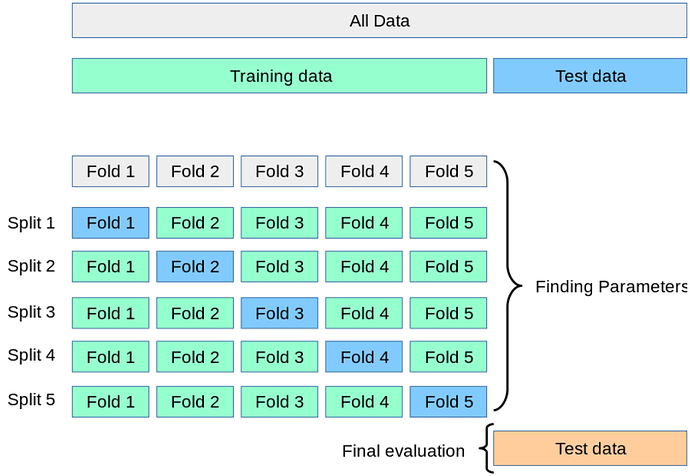

Per individuare la configurazione ottimale della rete neurale — ovvero l’architettura, gli iperparametri, la funzione di attivazione e il tipo di regolarizzazione — è stata adottata la tecnica di **K-Fold Cross Validation**.

Il training set viene suddiviso in *k* sottoinsiemi (fold). Vengono quindi eseguiti *k* cicli di addestramento, dove, ad ogni iterazione, uno dei *k* fold viene utilizzato come **validation set**, mentre i restanti *k-1* fold vengono utilizzati per l’**addestramento**.

Al termine di ogni ciclo, si calcola lo **score** sul validation set. Una volta completate tutte le *k* iterazioni, si calcola la **media degli score** ottenuti. La configurazione che ottiene lo score medio più alto viene selezionata come migliore.

Nel nostro caso, lo **score** utilizzato per valutare le prestazioni della rete è l’**accuratezza**.



In [ ]:
def k_fold_cross_validation(X, y, k, epochs, combinations):
    best_combination = {
        'accuracy': 0,
        'architecture': None,
        'activation': None,
        'batch_size': None,
        'learning_rate': None,
        'reg_rate': None,
        'reg_type': None
    }

    for combination in combinations:
        clear_output(wait=True)
        print(f"Best combination : {best_combination}")
        print(f"Testing combination: {combination}")

        # Shuffle
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Dividi in k folds
        folds_X = np.array_split(X_shuffled, k)
        folds_y = np.array_split(y_shuffled, k)

        total_accuracy = 0

        for i in range(k):
            print(f"Validation Fold {i + 1}")

            # Validation fold
            X_val = folds_X[i]
            y_val = folds_y[i]

            # Training folds (I restanti)
            X_train = np.concatenate([folds_X[j] for j in range(k) if j != i])
            y_train = np.concatenate([folds_y[j] for j in range(k) if j != i])

            # Addestramento del modello
            nn = NeuralNetwork(combination[0], combination[1])
            nn.fit(epochs=epochs, X=X_train, y=y_train,
                   minibatch_size=combination[2],
                   learning_rate=combination[3],
                   reg_rate=combination[4],
                   reg_type=combination[5]
                   )

            accuracy = nn.evaluate_accuracy(X_val, y_val)
            print(f"Validation fold {i + 1} Accuracy: {accuracy:.4f}")
            total_accuracy += accuracy

        average_accuracy = total_accuracy / k
        print(f"Combination: {combination}, Average Accuracy: {average_accuracy:.4f}")

        if average_accuracy > best_combination['accuracy']:
            print("New best combination found!")
            best_combination['accuracy'] = average_accuracy
            best_combination['architecture'] = combination[0]
            best_combination['activation'] = combination[1]
            best_combination['batch_size'] = combination[2]
            best_combination['learning_rate'] = combination[3]
            best_combination['reg_rate'] = combination[4]
            best_combination['reg_type'] = combination[5]

        time.sleep(2)

    clear_output(wait=True)
    print(f"Best combination: {best_combination}")
    return best_combination

Sono state provate 18 combinazioni differenti per ogni funzione di attivazione, per un totale di 54 configurazioni candidate.

In [ ]:
#Struttura : [[struttura della rete], funzione di attivazione, minibatch size, learning rate, regularization rate, tipo di regolarizzazione]

combinations = [
    # ReLU
    [[X_train_transformed.shape[1], 128, 128, Y_train_encoder.shape[1]]   , "relu", 32, 0.01, 0.01, "l2"],
    [[X_train_transformed.shape[1], 64, 64, Y_train_encoder.shape[1]]     , "relu", 16, 0.01, 0.005, "l1"],
    [[X_train_transformed.shape[1], 32, 32, Y_train_encoder.shape[1]]     , "relu", 16, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "relu", 16, 0.001, 0.005, "l1"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "relu", 32, 0.001, 0.05, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "relu", 64, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "relu", 64, 0.0001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "relu", 32, 0.01, 0.05, "l1"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "relu", 32, 0.001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "relu", 32, 0.001, 0.005, "l1"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "relu", 32, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 32, 64, Y_train_encoder.shape[1]]     , "relu", 32, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 32, 64, Y_train_encoder.shape[1]]     , "relu", 64, 0.0001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 24, 12, Y_train_encoder.shape[1]]     , "relu", 32, 0.001, 0.01, "l1"],
    [[X_train_transformed.shape[1], 24, 12, Y_train_encoder.shape[1]]     , "relu", 32, 0.001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 16, 8, Y_train_encoder.shape[1]]      , "relu", 128, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 16, 8, Y_train_encoder.shape[1]]      , "relu", 32, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 24, 12, 6, Y_train_encoder.shape[1]]  , "relu", 64, 0.01, 0.005, "l1"],


    # Tanh
    [[X_train_transformed.shape[1], 128, 128, Y_train_encoder.shape[1]]   , "tanh", 32, 0.01, 0.01, "l2"],
    [[X_train_transformed.shape[1], 64, 64, Y_train_encoder.shape[1]]     , "tanh", 16, 0.01, 0.005, "l1"],
    [[X_train_transformed.shape[1], 32, 32, Y_train_encoder.shape[1]]     , "tanh", 16, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "tanh", 16, 0.001, 0.005, "l1"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "tanh", 32, 0.001, 0.05, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "tanh", 64, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "tanh", 64, 0.0001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "tanh", 32, 0.01, 0.05, "l1"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "tanh", 32, 0.001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "tanh", 32, 0.001, 0.005, "l1"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "tanh", 32, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 32, 64, Y_train_encoder.shape[1]]     , "tanh", 32, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 32, 64, Y_train_encoder.shape[1]]     , "tanh", 64, 0.0001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 24, 12, Y_train_encoder.shape[1]]     , "tanh", 32, 0.001, 0.01, "l1"],
    [[X_train_transformed.shape[1], 24, 12, Y_train_encoder.shape[1]]     , "tanh", 32, 0.001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 16, 8, Y_train_encoder.shape[1]]      , "tanh", 128, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 16, 8, Y_train_encoder.shape[1]]      , "tanh", 32, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 24, 12, 6, Y_train_encoder.shape[1]]  , "tanh", 64, 0.01, 0.005, "l1"],


    # Leaky ReLU
    [[X_train_transformed.shape[1], 128, 128, Y_train_encoder.shape[1]]   , "leaky_relu", 32, 0.01, 0.01, "l2"],
    [[X_train_transformed.shape[1], 64, 64, Y_train_encoder.shape[1]]     , "leaky_relu", 16, 0.01, 0.005, "l1"],
    [[X_train_transformed.shape[1], 32, 32, Y_train_encoder.shape[1]]     , "leaky_relu", 16, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "leaky_relu", 16, 0.001, 0.005, "l1"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.001, 0.05, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "leaky_relu", 64, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "leaky_relu", 64, 0.0001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.01, 0.05, "l1"],
    [[X_train_transformed.shape[1], 32, 16, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.001, 0.005, "l1"],
    [[X_train_transformed.shape[1], 16, 32, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 32, 64, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 32, 64, Y_train_encoder.shape[1]]     , "leaky_relu", 64, 0.0001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 24, 12, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.001, 0.01, "l1"],
    [[X_train_transformed.shape[1], 24, 12, Y_train_encoder.shape[1]]     , "leaky_relu", 32, 0.001, 0.01, "l2"],
    [[X_train_transformed.shape[1], 16, 8, Y_train_encoder.shape[1]]      , "leaky_relu", 128, 0.001, 0.05, "l1"],
    [[X_train_transformed.shape[1], 16, 8, Y_train_encoder.shape[1]]      , "leaky_relu", 32, 0.01, 0.001, "l2"],
    [[X_train_transformed.shape[1], 24, 12, 6, Y_train_encoder.shape[1]]  , "leaky_relu", 64, 0.01, 0.005, "l1"],
]

Si è deciso di proseguire con una 10-fold cross validation, addestrando il modello per 20 epoche ad ogni iterazione.

In [ ]:
# @title Da eseguire per prova personale
best_combination = k_fold_cross_validation(X_train_transformed, Y_train_encoder, 10, 20, combinations)

In [ ]:
best_combination = k_fold_cross_validation(X_train_transformed, Y_train_encoder, 10, 20, combinations)

Best combination: {'accuracy': np.float64(0.74727729700332), 'architecture': [12, 128, 128, 4], 'activation': 'tanh', 'batch_size': 32, 'learning_rate': 0.01, 'reg_rate': 0.01, 'reg_type': 'l2'}


## 5. Addestramento della migliore configurazione di rete e di iper-parametri

Terminata la procedura di k-fold cross validation, addestriamo il modello con la miglior configurazione trovata, per un numero maggiore di epoche.

In [ ]:
nn = NeuralNetwork(best_combination["architecture"], best_combination["activation"])

In [ ]:
# @title Da eseguire per prova personale
nn.fit(epochs = 125,
       X= X_train_transformed,
       y = Y_train_encoder,
       minibatch_size = best_combination["batch_size"],
       learning_rate = best_combination["learning_rate"],
       reg_rate = best_combination["reg_rate"],
       reg_type = best_combination["reg_type"],
       show_plots = True
       )

Epoch 1/125 - Train loss: 1.0962 - Train accuracy: 0.5322
Epoch 2/125 - Train loss: 1.1288 - Train accuracy: 0.5853
Epoch 3/125 - Train loss: 1.0110 - Train accuracy: 0.6218
Epoch 4/125 - Train loss: 0.9801 - Train accuracy: 0.6684
Epoch 5/125 - Train loss: 0.9673 - Train accuracy: 0.6376
Epoch 6/125 - Train loss: 0.9548 - Train accuracy: 0.6364
Epoch 7/125 - Train loss: 0.9542 - Train accuracy: 0.6136
Epoch 8/125 - Train loss: 0.8993 - Train accuracy: 0.6965
Epoch 9/125 - Train loss: 0.8277 - Train accuracy: 0.6819
Epoch 10/125 - Train loss: 0.8950 - Train accuracy: 0.6802
Epoch 11/125 - Train loss: 0.8697 - Train accuracy: 0.6760
Epoch 12/125 - Train loss: 0.8285 - Train accuracy: 0.7004
Epoch 13/125 - Train loss: 0.9327 - Train accuracy: 0.6758
Epoch 14/125 - Train loss: 0.8937 - Train accuracy: 0.6386
Epoch 15/125 - Train loss: 0.8980 - Train accuracy: 0.7045
Epoch 16/125 - Train loss: 0.8761 - Train accuracy: 0.6681
Epoch 17/125 - Train loss: 0.8392 - Train accuracy: 0.6673
Epoch 

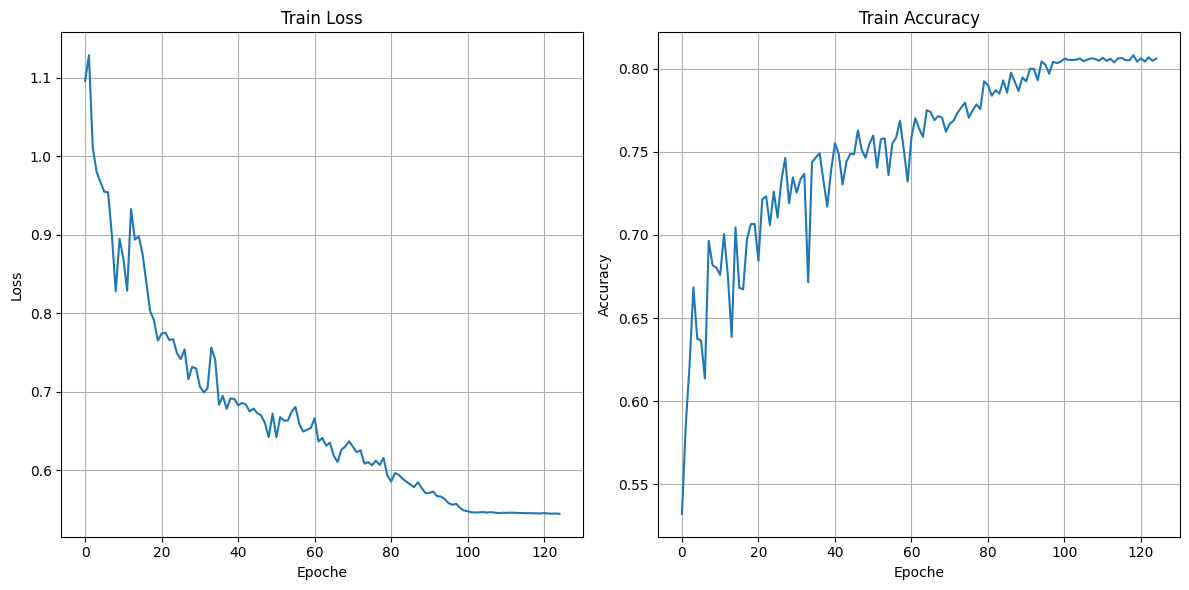

In [ ]:
nn.fit(epochs = 125,
       X= X_train_transformed,
       y = Y_train_encoder,
       minibatch_size = best_combination["batch_size"],
       learning_rate = best_combination["learning_rate"],
       reg_rate = best_combination["reg_rate"],
       reg_type = best_combination["reg_type"],
       show_plots = True
       )

L'andamento della loss sembra rispettare il comportamento tipico dei metodi stocastici, ovvero un elevato decremento nelle prime iterazioni, seguito da oscillazioni nell'intorno del valore minimo.

## 6. Analisi dei risultati ottenuti

Una volta addestrato il modello migliore, dobbiamo valutarne il comportamento sui dati del test set. Iniziamo calcolando l'accuracy globale.

In [ ]:
# @title Da eseguire per prova personale
nn.evaluate_accuracy(X_test_transformed, Y_test_encoder)

In [ ]:
nn.evaluate_accuracy(X_test_transformed, Y_test_encoder)

np.float64(0.7600796416127427)

Il risultato ottenuto è coerente con ciò che si è visto durante la fase di addestramento, dove il valore massimo di accuratezza raggiunto oscillava intorno a 0.80. Il risultato ottenuto evidenzia che il modello, durante la fase di training, non è caduto in overfitting.



---

Procediamo ora con la visualizzazione della matrice di confusione, per avere un quadro più chiaro delle performance per ogni classe.



In [ ]:
y_pred = nn.predict(X_test_transformed)

In [ ]:
def reverse_one_hot(y_true):
  y_true_reversed = []
  for i in range(y_true.shape[0]):
    y_true_reversed.append(classi[np.argmax(y_true[i])])
  return y_true_reversed

In [ ]:
def reverse(y_pred):
  y_labeled = []
  for i in range(len(y_pred)):
    y_labeled.append(classi[y_pred[i]])
  return y_labeled

Le due funzioni di reverse servono a trasformare la codifica *One Hot Encoding* in una codfica a classi, per rendere i grafici più leggibili.

In [ ]:
def plot_confusion(y_true, y_pred):
    labels = unique_labels(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(cm, index=[str(l) for l in labels], columns=[str(l) for l in labels])

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predette')
    plt.ylabel('Vere')
    plt.title('Matrice di confusione')
    plt.show()

In [ ]:
# @title Da eseguire per prova personale
plot_confusion(reverse_one_hot(Y_test_encoder), reverse(y_pred))

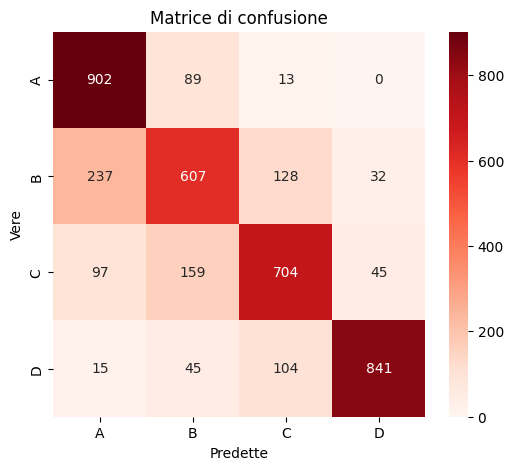

In [ ]:
plot_confusion(reverse_one_hot(Y_test_encoder), reverse(y_pred))

Possiamo notare che il modello classifica correttamente la maggior parte dei campioni appartenenti alle classi A e D, mentre commette più errori nel classificare le due rimanenti (B, C).



---


Per un'analisi più dettagliata, andiamo a calcolare, per ogni classe k :

**Precision**

La precision è la frazione di istanze correttamente classificate come appartenenti ad una specifica classe, fra tutte quelle che il modello ha predetto come appartenenti a quella classe.


$$
\text Precision_k  = \frac{\text True Positives_k} {\text True Positives_k + \text False Positives_k}
$$


**Recall**

Recall è la frazione di istanze di una classe predette correttamente, fra tutte le istanze che appartengono effettivamente a quella classe.

$$
\text Recall_k = \frac{\text True Positives_k }{\text True Positives_k + \text False Negatives_k}
$$

**F1 Score**

Lo score F1 è la media armonica fra precision e recall :

$$
F1_k = 2 \times \frac{\text Precision_k \times \text Recall_k}{\text Precision_k + \text Recall_k}
$$




---

Infine mostriamo le metriche globali del modello (*Macro averages*), andando a calcolare la media aritmetica per ogni metrica.


In [ ]:
def accuracy_per_class(y_true, y_pred):
  y_true = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
  y_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred
  accuracy_per_class = {}
  for i in range(len(y_true)):
    if y_true[i] not in accuracy_per_class:
      accuracy_per_class[y_true[i]] = 0

    if y_true[i] == y_pred[i]:
      accuracy_per_class[y_true[i]] += 1

  for key in accuracy_per_class:
    accuracy_per_class[key] = accuracy_per_class[key] / np.count_nonzero(y_true == key)
  return accuracy_per_class

In [ ]:
def getMetrics(y_true, y_pred):
  accuracy = accuracy_per_class(y_true, y_pred)
  print("############################################################################################")
  print("METRICHE PER CLASSE")
  print("############################################################################################")
  print(f"Accuracy per classe: [{accuracy[0]}  {accuracy[1]}  {accuracy[2]}  {accuracy[3]}]")

  reversed_y_true = reverse_one_hot(y_true)
  reversed_y_pred = reverse(y_pred)

  precision = precision_score(reversed_y_true, reversed_y_pred, average=None)
  recall = recall_score(reversed_y_true, reversed_y_pred, average=None)
  f1 = f1_score(reversed_y_true, reversed_y_pred, average = None)

  print("Precision per classe:", precision)
  print("Recall per clases:", recall)
  print("F1-score per classe:", f1)

  # Macro averaged Precision and Recall
  macro_precision = precision_score(reversed_y_true, reversed_y_pred, average='macro')
  macro_recall = recall_score(reversed_y_true, reversed_y_pred, average='macro')
  macro_f1 = f1_score(reversed_y_true, reversed_y_pred, average='macro')

  print("############################################################################################")
  print("MACRO AVERAGES")
  print("############################################################################################")
  print("Macro Precision:", macro_precision)
  print("Macro Recall:", macro_recall)
  print("Macro F1-score:", macro_f1)


In [ ]:
# @title Da eseguire per prova personale
getMetrics(Y_test_encoder, y_pred)

In [ ]:
getMetrics(Y_test_encoder, y_pred)

############################################################################################
METRICHE PER CLASSE
############################################################################################
Accuracy per classe: [0.898406374501992  0.6045816733067729  0.700497512437811  0.83681592039801]
Precision per classe: [0.72102318 0.67444444 0.74183351 0.916122  ]
Recall per clases: [0.89840637 0.60458167 0.70049751 0.83681592]
F1-score per classe: [0.8        0.63760504 0.72057318 0.87467499]
############################################################################################
MACRO AVERAGES
############################################################################################
Macro Precision: 0.763355784803344
Macro Recall: 0.7600753701611465
Macro F1-score: 0.7582133030575517


Come ci aspettavamo, le metriche delle classi B e C sono inferiori rispetto alle classi A e D. Questi risultati sono conformi a quanto già osservato nella matrice di confusione.